In [1]:
# 1. DATA PREPARATION 
import numpy as np
import pandas as pd

### Read in data
bes_data = pd.read_csv("bes_data_nov19.csv")

### Quick glance at features
bes_data.head()

,age,income,living_situation,work_status,education,party_identity,religion,ethnicity,union_member,social_class,region,gender,marital_status,eu_vote,ability
0,1,3,own on mortgage,full time,0,1,No religion,White,0,Working class,East Midlands,0,Single,Leave,-0.282726
1,4,2,rent local authority,looking after family or home,2,1,Muslim,Asian,0,Working class,East Midlands,1,Single,Remain,-0.282726
2,6,9,own outright,retired,0,1,Christian - no denomination,White,0,Working class,East Midlands,0,Married,Leave,-0.306999
3,6,10,own outright,retired,7,1,Christian - no denomination,White,0,Working class,East Midlands,0,Married,Remain,0.847357
4,6,4,own outright,part time,0,2,Christian - no denomination,White,0,None,East Midlands,1,Married,Remain,0.079292


In [2]:
### Check party identity categories and counts

bes_data.party_identity.value_counts()
# 0 None / No party/ uncommitted
# 1 Labour
# 2 Conservative
# 3 Liberal Democrat
# 4 Scottish National Party (SNP)
# 5 Plaid Cymru
# 6 Green Party
# 7 United Kingdom Independence Party (UKIP)

1    646
2    511
0    212
3    105
7     43
4     39
6     24
5     11
Name: party_identity, dtype: int64

In [3]:
### Preprocess ordinal features

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

bes_data.age = ordinal_encoder.fit_transform(bes_data.age.values.reshape(-1, 1))
bes_data.income = ordinal_encoder.fit_transform(bes_data.income.values.reshape(-1, 1))
bes_data.education = ordinal_encoder.fit_transform(bes_data.education.values.reshape(-1, 1))

### Preprocess nominal categories

from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(dtype=int, sparse=True)

living_situation = pd.DataFrame(
    onehot.fit_transform(bes_data[['living_situation']])\
    .toarray(),
    columns=['own outright', 'own on mortgage', 'rent private', 'rent local authority', 'housing assoc'])

work_status = pd.DataFrame(
    onehot.fit_transform(bes_data[['work_status']])\
    .toarray(),
    columns=['full time', 'part time', 'unemployed', 'student', 'retired', 'looking after family or home'])

religion = pd.DataFrame(
    onehot.fit_transform(bes_data[['religion']])\
    .toarray(),
    columns=['Christian - no denomination', 'Church of England or Anglican', 'Hindu', 'Muslim', 'No religion', 'Other', 'Roman Catholic'])

ethnicity = pd.DataFrame(
    onehot.fit_transform(bes_data[['ethnicity']])\
    .toarray(),
    columns=['White', 'Asian', 'Black', 'Mixed', 'Other'])

social_class = pd.DataFrame(
    onehot.fit_transform(bes_data[['social_class']])\
    .toarray(),
    columns=['Working class', 'Middle class', 'Other', 'None'])

region = pd.DataFrame(
    onehot.fit_transform(bes_data[['region']])\
    .toarray(),
    columns=['East Midlands', 'Eastern', 'London', 'North East','North West','Scotland','South East','South West','Wales','West Midlands','Yorkshire & Humber'])

marital_status = pd.DataFrame(
    onehot.fit_transform(bes_data[['marital_status']])\
    .toarray(),
    columns=['Divorced', 'Living with partner', 'Married', 'Separated', 'Single', 'Widowed'])

eu_vote = pd.DataFrame(
    onehot.fit_transform(bes_data[['eu_vote']])\
    .toarray(),
    columns=['Leave', 'Remain', 'Did not vote'])

bes_data = pd.concat([bes_data, living_situation, work_status, religion, ethnicity, social_class, region, marital_status, eu_vote], axis=1, sort=False)
bes_data = bes_data.drop(['living_situation', 'work_status', 'religion', 'ethnicity', 'social_class', 'region', 'marital_status', 'eu_vote'], axis=1)


In [4]:
### Prepare train and test sets for three regression models

from sklearn.model_selection import train_test_split

y = bes_data['party_identity']

X_demographic = bes_data.drop(['party_identity', 'Leave', 'Remain', 'Did not vote'], axis=1)
X_demographic_train, X_demographic_test, y_demographic_train, y_demographic_test = train_test_split(X_demographic, y, test_size = 0.2, random_state = 42)

X_euVote = bes_data.drop(['party_identity'], axis=1)
X_euVote_train, X_euVote_test, y_euVote_train, y_euVote_test = train_test_split(X_euVote, y, test_size = 0.2, random_state = 42)

In [5]:
# 2. TWO MULTINOMIAL LOGISTIC REGRESSION (SOFTMAX) MODELS

from sklearn.linear_model import LogisticRegression

softmax_reg_demographic = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100000, random_state=42)
softmax_reg_demographic.fit(X_demographic_train.values, y_demographic_train.values)

softmax_reg_euVote = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100000, random_state=42)
softmax_reg_euVote.fit(X_euVote_train.values, y_euVote_train.values)

LogisticRegression(max_iter=100000, multi_class='multinomial', random_state=42)

<IPython.core.display.Javascript object>


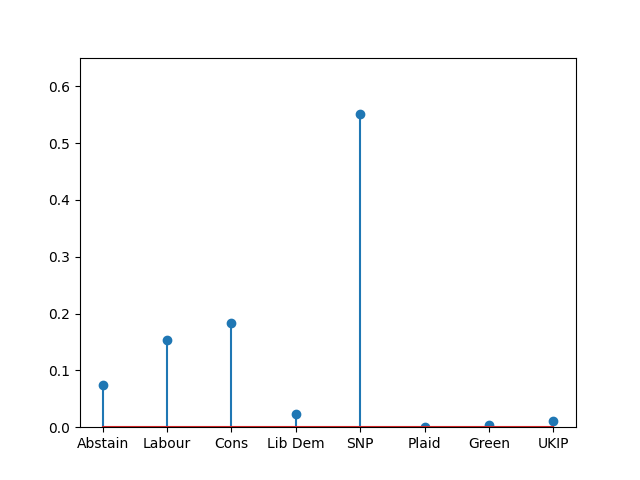

In [6]:
### For illustration, predict probabilites on first observation
actual_prob = softmax_reg_demographic.predict_proba([X_demographic_train.iloc[0,:]])

%matplotlib notebook
import matplotlib.pyplot as plt

x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
 
plt.stem(x, actual_prob.tolist()[0], use_line_collection=True)
plt.ylim(0, max(actual_prob.tolist()[0]) + 0.1)
plt.show()

In [7]:
# 3. MODEL EVALUATION

### Classification accuracy

demographic_acc = softmax_reg_demographic.score(X_demographic_test.values,y_demographic_test.values)

from sklearn.dummy import DummyClassifier

dummy_demographic_model = DummyClassifier()
dummy_demographic_model.fit(X_demographic_train.values, y_demographic_train.values)
dummy_demographic_acc = dummy_demographic_model.score(X_demographic_test.values,y_demographic_test.values)

euVote_acc = softmax_reg_euVote.score(X_euVote_test.values,y_euVote_test.values)

dummy_euVote_model = DummyClassifier()
dummy_euVote_model.fit(X_euVote_train.values, y_euVote_train.values)
dummy_euVote_acc = dummy_euVote_model.score(X_euVote_test.values,y_euVote_test.values)

print("DEMOGRAPHIC MODELS:")
print("Demographic: ", demographic_acc)
print("Dummy: ", dummy_demographic_acc)
print("EU VOTE MODELS:")
print("EU vote: ", euVote_acc)
print("Dummy: ", dummy_euVote_acc)

DEMOGRAPHIC MODELS:
Demographic:  0.4952978056426332
Dummy:  0.3949843260188088
EU VOTE MODELS:
EU vote:  0.5015673981191222
Dummy:  0.3949843260188088


In [8]:
### Log-loss
from sklearn.metrics import log_loss

y_pred_demo = softmax_reg_demographic.predict_proba(X_demographic_test.values)
logloss_demo = log_loss(y_demographic_test, y_pred_demo, labels=[0,1,2,3,4,5,6,7])

y_pred_eu = softmax_reg_euVote.predict_proba(X_euVote_test.values)
logloss_eu = log_loss(y_euVote_test, y_pred_eu, labels=[0,1,2,3,4,5,6,7])

def display_loglosses(dem,eu):
    print("LOG-LOSSES:")
    print("Demographic Model:", logloss_demo)
    print("EU Vote Model:", logloss_eu)

display_loglosses(logloss_demo, logloss_eu)

LOG-LOSSES:
Demographic Model: 1.3134925456261985
EU Vote Model: 1.273035528890643


In [9]:
### For context, a (very) dumb log-loss on 8 classes is -log(1/8), given balanced classes

import math

print("VERY DUMB LOG-LOSS:")
print(-math.log(1/8)) 

### Calculate a (less) dumb log-loss for unbalanced case that simply uses base rates
### (Since all train sets contain the same observations, only one set needs to be used here)

all_votes = y_demographic_train.value_counts().sum()

y_demographic_train.value_counts()[0]

novote = y_demographic_train.value_counts()[0]/all_votes
labour = y_demographic_train.value_counts()[1]/all_votes
cons = y_demographic_train.value_counts()[2]/all_votes
libdem = y_demographic_train.value_counts()[3]/all_votes
snp = y_demographic_train.value_counts()[4]/all_votes
plaid = y_demographic_train.value_counts()[5]/all_votes
green = y_demographic_train.value_counts()[6]/all_votes
ukip = y_demographic_train.value_counts()[7]/all_votes

y_array = np.array([novote,labour,cons,libdem,snp,plaid,green,ukip])
y_array_tiled = np.tile(y_array,(y_demographic_test.shape[0],1))
logloss_dumb = log_loss(y_demographic_test, y_array_tiled,labels=[0,1,2,3,4,5,6,7])

print("LESS DUMB LOG-LOSS:")
print(logloss_dumb)

VERY DUMB LOG-LOSS:
2.0794415416798357
LESS DUMB LOG-LOSS:
1.4893560795840097


In [10]:
# 4. SIMULATION OF FULLY INFORMED (REPORTED) PREFERENCES

### Find maximum ability value
maxValue = bes_data['ability'].max()
maxValue

0.847356952624131

<IPython.core.display.Javascript object>


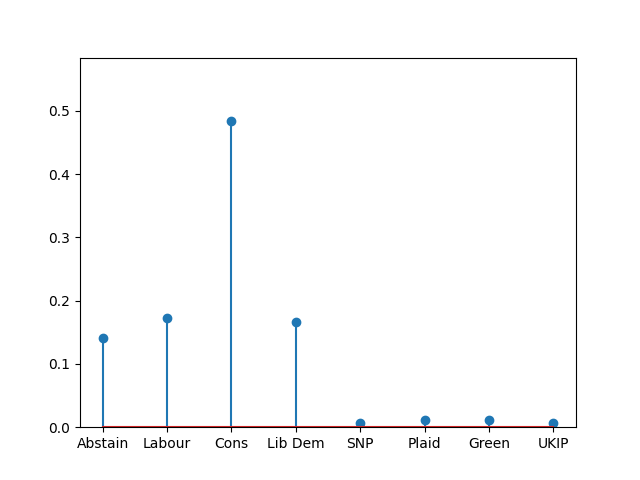

In [11]:
### Take first observation from test data as example
obs = X_demographic_test.iloc[0,:].copy()

### Assign max ability value to that observation
obs[5] = maxValue

### Predict informed vote using demographic model
softmax_reg_demographic.predict([obs])

### Predict full probability distribution over all parties (and abstain) using same model
full_inf_prob = softmax_reg_demographic.predict_proba([obs])

### Plot the distribution
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
values=full_inf_prob.tolist()[0]

plt.stem(x, values, use_line_collection=True)
plt.ylim(0, max(values) + 0.1)
plt.show()

<IPython.core.display.Javascript object>


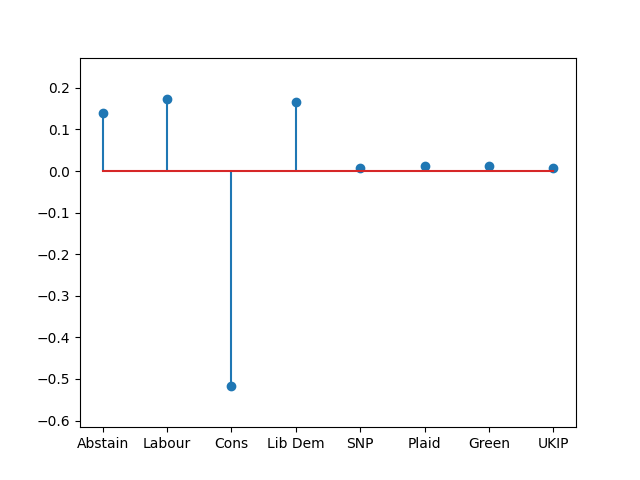

In [12]:
# 5. DIFFERENCE BETWEEN ACTUAL AND FULLY INFORMED VOTE

### Calculate difference between the person's actual vote and their fully informed distribution
actual_vote = [0,0,0,0,0,0,0,0]
actual_vote[y_demographic_test.iloc[0]] = 1
prob_diff = np.subtract(full_inf_prob, actual_vote)

### Plot that difference
values=prob_diff.tolist()[0]

plt.stem(x, values, use_line_collection=True)
plt.ylim(min(prob_diff.tolist()[0]) - 0.1, max(prob_diff.tolist()[0]) + 0.1)
plt.show()

<IPython.core.display.Javascript object>


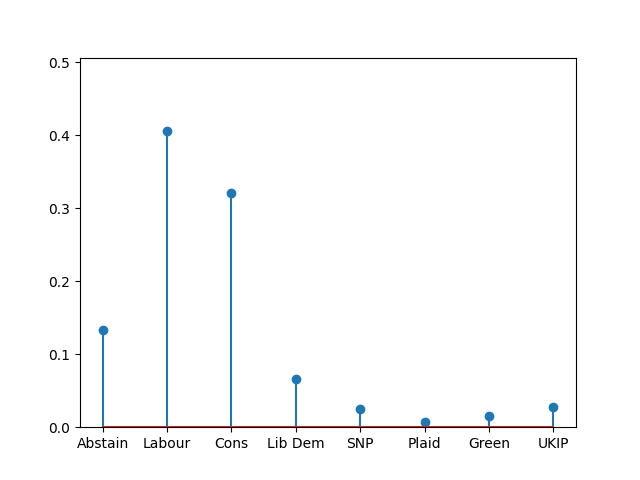

In [13]:
# 6. AGGREGATE DIFFERENCE BETWEEN ACTUAL AND FULLY INFORMED VOTES

### Calculate actual proportions of support
all_votes = bes_data['party_identity'].value_counts().sum()

novote = bes_data['party_identity'].value_counts()[0]/all_votes
lab = bes_data['party_identity'].value_counts()[1]/all_votes
cons = bes_data['party_identity'].value_counts()[2]/all_votes
libdem = bes_data['party_identity'].value_counts()[3]/all_votes
snp = bes_data['party_identity'].value_counts()[4]/all_votes
plaid = bes_data['party_identity'].value_counts()[5]/all_votes
green = bes_data['party_identity'].value_counts()[6]/all_votes
ukip = bes_data['party_identity'].value_counts()[7]/all_votes

### Plot proportions of actual support
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
values_actual=[novote,lab,cons,libdem,snp,plaid,green,ukip,]
 
plt.stem(x, values_actual, use_line_collection=True)
plt.ylim(0, max(values_actual) + 0.1)
plt.show()

<IPython.core.display.Javascript object>


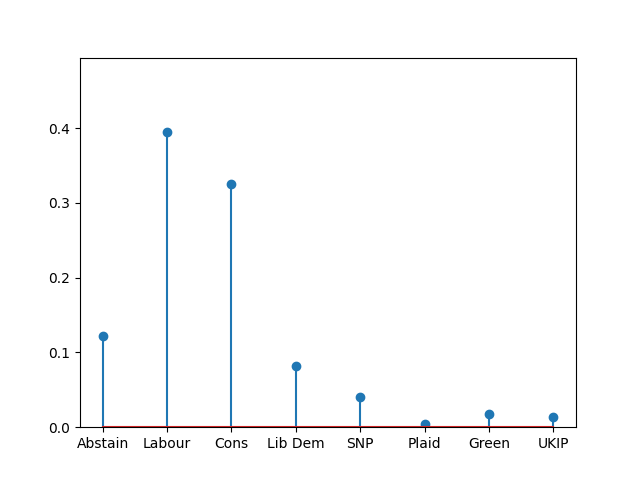

In [14]:
### Copy X and assign max ability value to all observations
all_obs = X_demographic_test.copy()
all_obs['ability'] = maxValue

### Calculate fully informed distribution for each observation
all_obs_full_inf = softmax_reg_demographic.predict_proba(all_obs.values)

### Calculate the mean probability for each party (or abstain)
mean_full_inf = all_obs_full_inf.mean(axis = 0)

### Plot proportions of simulated fully informed support
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
values_sim=[mean_full_inf[0],mean_full_inf[1],mean_full_inf[2],mean_full_inf[3],mean_full_inf[4],mean_full_inf[5],mean_full_inf[6],mean_full_inf[7]]

plt.stem(x, values_sim, use_line_collection=True)
plt.ylim(0, max(values_sim) + 0.1)
plt.show()

<IPython.core.display.Javascript object>


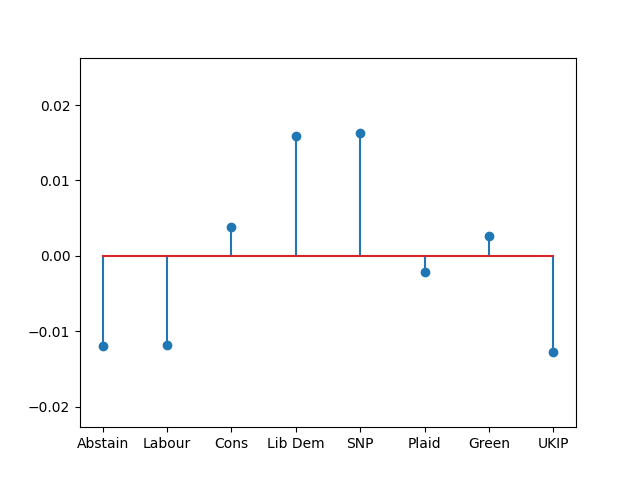

In [15]:
### Plot aggregate information effect, i.e., difference between actual and simulated support
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
support_diff = np.subtract(values_sim, values_actual)

plt.stem(x, support_diff, use_line_collection=True)
plt.ylim(min(support_diff) - 0.01, max(support_diff) + 0.01)
plt.show()